### Creating a LSTM Model

In [1]:
from pymongo import MongoClient
import numpy as np
import os
import random
import tensorflow as tf
import pandas as pd
from tqdm import tqdm 
import matplotlib.pyplot as plt
%matplotlib inline
tqdm.pandas()

In [2]:
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.layers import LSTM , Dense , Flatten , Dropout , Input
from tensorflow.keras.callbacks import TensorBoard , EarlyStopping

In [3]:

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [4]:
actions = np.array(['hello' , 'thankyou' , 'iloveyou'])

# Creating Label Map 

label_map = {label:num for num , label in enumerate(actions)}

In [5]:
label_map

{'hello': 0, 'thankyou': 1, 'iloveyou': 2}

In [6]:
tf.random.set_seed(17)
np.random.seed(17)
random.seed(17)

#### 1. Extracting Data from MongoDB

In [7]:
connection = MongoClient('localhost' , 27017)
db = connection['mydb']
collection = db['Preprocessed_Landmark_Data']

In [8]:
cursor = collection.find({})
df = pd.DataFrame(list(cursor))

In [9]:
df['Landmarks'] = df['Landmarks'].progress_apply(lambda landmarks : [np.array(x) if isinstance(x , list) else x for x in landmarks])

100%|██████████| 300/300 [00:00<00:00, 416.08it/s]


In [10]:
df['Landmarks'][0]

[array([ 0.5282082 ,  0.69970912, -0.78407443, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.55254889,  0.63023722, -0.78952068, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.55559933,  0.61130732, -0.7708981 , ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.56082523,  0.60821176, -0.77176523, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.56795919,  0.6058867 , -0.81826133, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.56992733,  0.60519606, -0.77989995, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.57354176,  0.60459828, -0.86566448, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.57485545,  0.60356939, -0.90603018, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.5737077 ,  0.60355467, -0.84255922, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.57421315,  0.60291201, -1.03197324, ...,  0.        ,
         0.        ,  0.  

In [11]:
X = np.array(df['Landmarks'].tolist())
labels_list = (df['Labels'].tolist())
y = to_categorical(labels_list).astype(int)


In [12]:
X.shape

(300, 30, 1662)

In [13]:
y.shape

(300, 3)

In [14]:
X

array([[[ 0.5282082 ,  0.69970912, -0.78407443, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.55254889,  0.63023722, -0.78952068, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.55559933,  0.61130732, -0.7708981 , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.62980717,  0.59732503, -1.28325009, ...,  0.47731709,
          0.40780509, -0.02713273],
        [ 0.63064581,  0.59841526, -1.25939536, ...,  0.48286542,
          0.40332043, -0.03363072],
        [ 0.62974828,  0.59842288, -1.20764422, ...,  0.44305485,
          0.3869282 , -0.03627616]],

       [[ 0.62721896,  0.59237534, -1.21063435, ...,  0.39933065,
          0.32641381, -0.06619024],
        [ 0.62298107,  0.5921942 , -1.05823302, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.62047112,  0.59255719, -1.09682631, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.53934711,  0.60268617, -0.99255943, ...,  

#### 2. Performing Train-test split
- using 95-5  percent train-test split

In [15]:
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=0.05)

In [16]:
print("X-train shape:" , X_train.shape)
print("X-test shape:" , X_test.shape)
print("y-train shape:" , y_train.shape)
print("y-test shape:" , X_test.shape)

X-train shape: (285, 30, 1662)
X-test shape: (15, 30, 1662)
y-train shape: (285, 3)
y-test shape: (15, 30, 1662)


Creating LSTM Model Architecture

In [17]:
# Creating a Instance of Early Stopping

early_stopping_callback = EarlyStopping(
 monitor = 'val_loss',
 patience = 5,
 mode = 'min',
 restore_best_weights = True
)

In [18]:
X_train.shape

(285, 30, 1662)

In [19]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir = log_dir)

In [20]:
# Constructing LSTM Model

LSTM_model = Sequential()
LSTM_model.add(LSTM(64, return_sequences= True , activation = 'relu' , input_shape = (30 , 1662)))
LSTM_model.add(LSTM(128 , return_sequences= True , activation = 'relu'))
# model.add(LSTM(128 , return_sequences= True , activation = 'relu'))
LSTM_model.add(LSTM(64 , return_sequences= False , activation='relu'))
# model.add(Dense(128 , activation ='relu'))
# model.add(Dense(64 , activation ='relu'))
LSTM_model.add(Dense(64 , activation ='relu'))
LSTM_model.add(Dense(32 , activation = 'relu'))
LSTM_model.add(Dense(actions.shape[0] , activation='softmax'))

c:\Users\Sahil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
LSTM_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │       442,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 596,675 (2.28 MB)

 Trainable params: 596,675 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Compiling the Model 

LSTM_model.compile(optimizer='Adam' , loss = 'categorical_crossentropy' , metrics = ['categorical_accuracy'])

In [23]:
LSTM_model_history = LSTM_model.fit(X_train , y_train , epochs = 2000)

Epoch 1/2000
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - categorical_accuracy: 0.3160 - loss: 13.3798
Epoch 2/2000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - categorical_accuracy: 0.3779 - loss: 15.4216
Epoch 3/2000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - categorical_accuracy: 0.3242 - loss: 15.9685
Epoch 4/2000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - categorical_accuracy: 0.2963 - loss: 25.6541
Epoch 5/2000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - categorical_accuracy: 0.3220 - loss: 82.8006
Epoch 6/2000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - categorical_accuracy: 0.3791 - loss: 38.0651
Epoch 7/2000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - categorical_accuracy: 0.3223 - loss: 79.4214
Epoch 8/2000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_accuracy: 0.3826 - loss: 30.3231
Epoch 9/2000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - categorical_accuracy: 0.3257 - loss: 45.3878
Epoch 10/2000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_accuracy: 0.3800 - loss: 44.9898
Epoch 11/2000
9/9 ━

Visualizing the outcomes

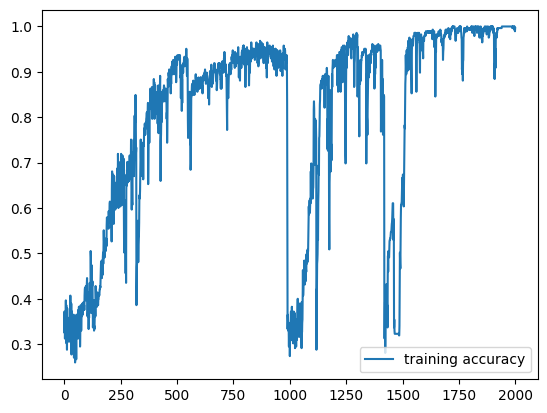

In [24]:
plt.plot(LSTM_model_history.history['categorical_accuracy'] , label = 'training accuracy')
plt.legend(loc ='lower right')

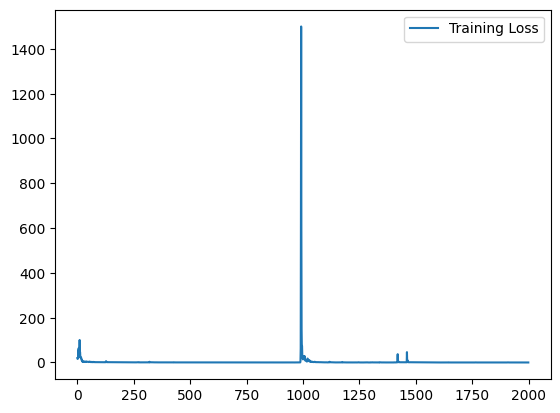

In [25]:
plt.plot(LSTM_model_history.history['loss'] , label = 'Training Loss')
plt.legend(loc = 'upper right')

In [26]:
LSTM_model.evaluate(X_test , y_test , verbose = 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - categorical_accuracy: 1.0000 - loss: 2.4594e-04


[0.00024594098795205355, 1.0]

#### 3. Predicting Results

In [27]:
predictions = LSTM_model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


In [28]:
predictions[0]

array([1.8784687e-06, 9.9999154e-01, 6.5414970e-06], dtype=float32)

In [29]:
actions[np.argmax(predictions[0])]

'thankyou'

In [30]:
actions[np.argmax(y_test[0])]

'thankyou'

In [31]:
results , actual = [] , []

for result in predictions:
  
  outcome = actions[np.argmax(result)]

  results.append(outcome)
  

for i in range(len(y_test)):

  act_out = actions[np.argmax(y_test[i])] 

  actual.append(act_out)


In [32]:
results

['thankyou',
 'hello',
 'thankyou',
 'thankyou',
 'iloveyou',
 'iloveyou',
 'iloveyou',
 'thankyou',
 'thankyou',
 'iloveyou',
 'hello',
 'thankyou',
 'thankyou',
 'thankyou',
 'hello']

In [33]:
actual

['thankyou',
 'hello',
 'thankyou',
 'thankyou',
 'iloveyou',
 'iloveyou',
 'iloveyou',
 'thankyou',
 'thankyou',
 'iloveyou',
 'hello',
 'thankyou',
 'thankyou',
 'thankyou',
 'hello']